In [33]:
%reload_ext autoreload
%autoreload 2

In [36]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [ ]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

In [61]:
from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [62]:


def slack_parser(path_channel):
    """Parse Slack data to extract useful information from JSON files."""
    
    # Step 1: Read all JSON files from the provided path
    json_files = glob.glob(f"{path_channel}/*.json")
    
    # Step 2: Combine all JSON files into a list
    combined_data = []
    for json_file in json_files:
        with open(json_file, 'r', encoding="utf8") as file:
            data = json.load(file)
            combined_data.extend(data)
    
    # Step 3: Extract required information from the Slack data
    messages = []
    for row in combined_data:
        if 'bot_id' in row.keys():
            continue
        else:
            message = {
                'msg_type': row['type'],
                'msg_content': row['text'],
                'sender_name': row.get('user_profile', {}).get('real_name', 'Not provided'),
                'msg_sent_time': row['ts']
            }
            if 'blocks' in row.keys() and row['blocks'] and 'elements' in row['blocks'][0] and row['blocks'][0]['elements'] and row['blocks'][0]['elements'][0]['elements']:
                message['msg_dist_type'] = row['blocks'][0]['elements'][0]['elements'][0].get('type', 'reshared')
            else:
                message['msg_dist_type'] = 'reshared'
            if 'thread_ts' in row.keys():
                message['time_thread_start'] = row['thread_ts']
            else:
                message['time_thread_start'] = 0
            if 'reply_users' in row.keys():
                message['reply_users'] = ",".join(row['reply_users'])
            else:
                message['reply_users'] = 0
            if 'reply_count' in row.keys():
                message['reply_count'] = row['reply_count']
                message['reply_users_count'] = row['reply_users_count']
                message['tm_thread_end'] = row['latest_reply']
            else:
                message['reply_count'] = 0
                message['reply_users_count'] = 0
                message['tm_thread_end'] = 0
            messages.append(message)
    
    # Step 4: Convert extracted information to a DataFrame
    df = pd.DataFrame(messages)
    
    # Step 5: Filter out messages sent by bots
    df = df[df['sender_name'] != 'Not provided']
    
    # Step 6: Set the 'channel' column based on the channel name in the provided path
    channel_name = path_channel.split('/')[-1].split('.')[0]
    df['channel'] = channel_name
    
    # Step 7: Reset the index of the DataFrame
    df = df.reset_index(drop=True)
    
    # Step 8: Return the resulting DataFrame
    return df

In [63]:
data_path = '../data/anonymized/all-community-building/'
parsed_slack = slack_parser(data_path)

In [64]:
#all users reply from community building
parsed_slack

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_users,reply_count,reply_users_count,tm_thread_end,channel
0,message,"hi all, looking forward to starting together, ...",Lawrence Braun,1661094957.241139,text,0,0,0,0,0,
1,message,hello everyone. it's my hope that you are doin...,Lynn Shepherd,1661151244.337329,text,0,0,0,0,0,
2,message,*community building session reminder!*:timer_c...,Lynn Shepherd,1661169000.633059,text,1661169000.633059,"U03UG0YHAUT,U03V1AM5TFA",3,2,1661169624.405079,
3,message,let's get ready to the first cbs of the progra...,David Nguyen,1661169461.106859,text,1661169000.633059,0,0,0,0,
4,message,the very first cbs is here,Lynn Shepherd,1661169547.570659,text,1661169000.633059,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...
7608,message,we will be emailing them out early next week,Lawrence Braun,1669113675.453199,text,1669113675.453199,U03UVHCV6KB,1,1,1669113786.862139,
7609,message,<@u03t89acuuw> is off this week,Lawrence Braun,1669113679.677989,user,0,0,0,0,0,
7610,message,okay thanks,Gregory Bowman,1669113786.862139,text,1669113675.453199,0,0,0,0,
7611,message,we need someone who prays for us like this. bz...,Dennis Parker,1669396046.109249,text,1669392749.586729,0,0,0,0,


In [65]:
def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r', encoding="utf-8") as slack_data:
            combined.append(slack_data)

    # print(combined)
    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for k in combined:
        slack_data = json.load(open(k.name, 'r', encoding="utf-8"))
    
        for i_count, i in enumerate(slack_data):
            
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))

    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    df_reaction['channel'] = channel
    return df_reaction

In [98]:
parse_dataframe =parse_slack_reaction(data_path, 'channel')

In [99]:
parse_dataframe

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
0,+1,12,"U03UFV7TUTV,U03U1HAG9TR,U03UFV7HFNF,U03U9EJR36...","hi all, looking forward to starting together, ...",U03U93GNNVB,channel
1,muscle,2,"U03UG0YHAUT,U03UUR571A5","hi all, looking forward to starting together, ...",U03U93GNNVB,channel
2,heart,2,"U03UUMM7Y8H,U03UD68RQH3","hi all, looking forward to starting together, ...",U03U93GNNVB,channel
3,+1,8,"U03UFV7HFNF,U03UG4Q7V42,U03U9EJR362,U03U1J51VF...",hello everyone. it's my hope that you are doin...,U03V1AM5TFA,channel
4,clap,2,"U03U1HAG9TR,U03UG0YHAUT",hello everyone. it's my hope that you are doin...,U03V1AM5TFA,channel
...,...,...,...,...,...,...
3186,white_check_mark,1,U03UG5VFN03,<!channel> where exactly can i find the certif...,U03UVHCV6KB,channel
3187,white_check_mark,3,"U03UVHCV6KB,U03UG0YHAUT,U03UFV7HFNF",we will be emailing them out early next week,U03U93GNNVB,channel
3188,grinning,6,"U03UUR571A5,U03UG0YHAUT,U03UJGP0C68,U03UJGRN5E...",you all need this kind of friend :rolling_on_t...,U03UG32J3PC,channel
3189,rolling_on_the_floor_laughing,3,"U03UG32J3PC,U03UFV7HFNF,U03UG1Z21JP",we need someone who prays for us like this. bz...,U03UJGRN5E0,channel


In [104]:
def replies_user(data: pd):
    grouped_df = data.groupby('user_id')['reaction_count'].sum()
    grouped_df = grouped_df.sort_values(ascending=False)
    grouped_df.plot(kind='bar', figsize=(15, 7.5))
    
    plt.title(' Reaction Count')
    plt.xlabel('User')
    plt.ylabel('reactions')
    plt.show()

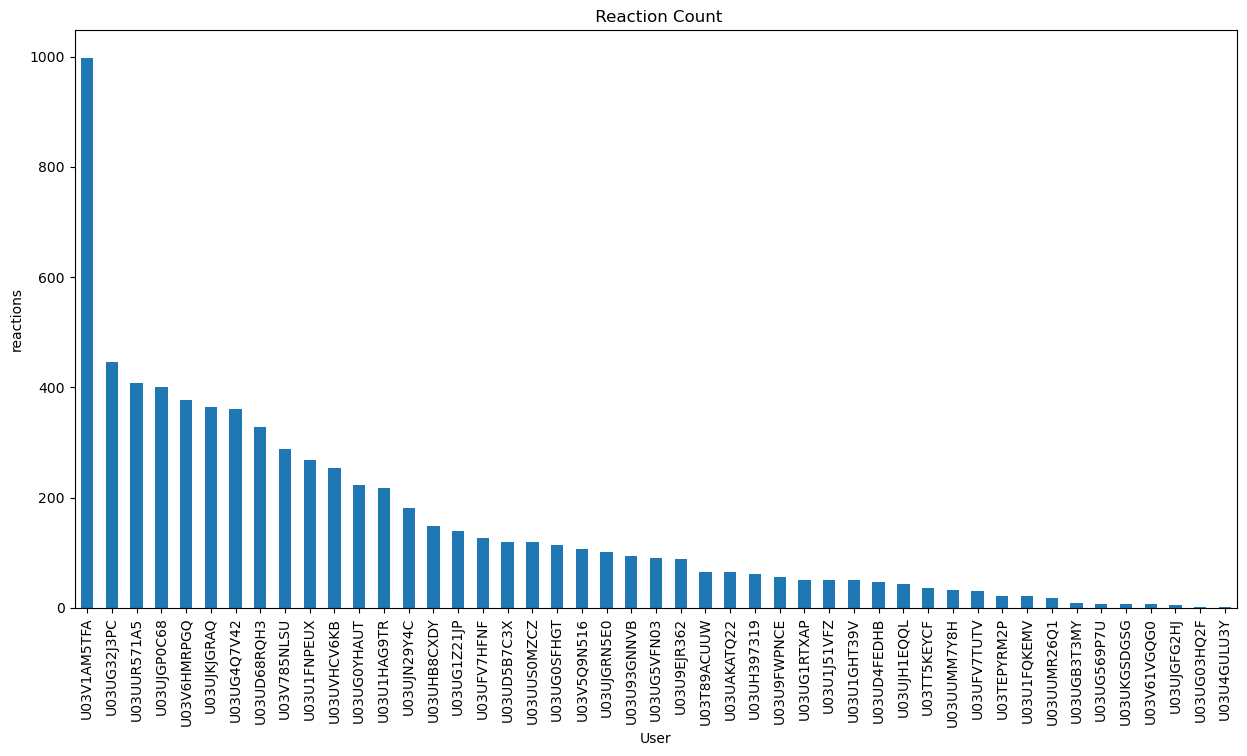

In [105]:
replies_user(parse_dataframe)

In [67]:
def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict

In [68]:
get_community_participation(data_path)

{'U03UG0YHAUT': 112,
 'U03V1AM5TFA': 515,
 'U03V785NLSU': 118,
 'U03UUS0MZCZ': 106,
 'U03UG32J3PC': 358,
 'U03U1HAG9TR': 135,
 'U03UG1RTXAP': 14,
 'U03UUMM7Y8H': 26,
 'U03UD68RQH3': 224,
 'U03UJGFG2HJ': 7,
 'U03U1FNPEUX': 145,
 'U03UG4Q7V42': 199,
 'U03UFV7HFNF': 53,
 'U03UD5B7C3X': 66,
 'U03UFV7TUTV': 39,
 'U03UHB8CXDY': 77,
 'U03UKGSDGSG': 6,
 'U03UUR571A5': 266,
 'U03UD4FEDHB': 24,
 'U03UP7V9Q57': 2,
 'U03UJN29Y4C': 55,
 'U03UVHCV6KB': 284,
 'U03UJKJGRAQ': 132,
 'U03U1FQKEMV': 3,
 'U03U9FWPNCE': 32,
 'U03TT5KEYCF': 13,
 'U03TEPYRM2P': 14,
 'U03UCCRJME2': 1,
 'U03U93GNNVB': 46,
 'U03U9EJR362': 39,
 'U03T89ACUUW': 39,
 'U03UJGP0C68': 168,
 'U03UJH1EQQL': 24,
 'U03UJGRN5E0': 28,
 'U03V5Q9N516': 44,
 'U03V6HMRPGQ': 164,
 'U03U1J51VFZ': 19,
 'U03UAKATQ22': 34,
 'U03UG0SFHGT': 42,
 'U03UH397319': 99,
 'U03UG5VFN03': 13,
 'U03UUMR26Q1': 15,
 'U03U4GULU3Y': 2,
 'U03UG1Z21JP': 80,
 'U03U1GHT39V': 6,
 'U03UGB3T3MY': 1,
 'U03UUP56MDF': 1,
 'U03V61VGQG0': 4}

In [69]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else: 
        print(f"{column} not in data")

In [70]:
def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))

In [96]:
    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [72]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

In [73]:
def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

In [74]:
def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

In [75]:
def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

In [76]:
def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

In [92]:
draw_user_reaction(data)

NameError: name 'data' is not defined

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [80]:
# which user has the highest number of reply counts?
#user rely from all channels 
def reply_dataframe()->pd:
    ROOT_DIR = '../data/anonymized/'
    sl = SlackDataLoader(ROOT_DIR)
    channels = sl.get_channels()
    channel_names = [channels[i]['name'] for i in range(len(channels))]
    data_frames = []

    for name in channel_names:
        channel_path = ROOT_DIR + name + '/'
        channel_dataframe = slack_parser(channel_path)
        data_frames.append(channel_dataframe)
    
    all_data = pd.concat(data_frames, ignore_index=True)
    return all_data 

In [81]:
dframe = reply_dataframe()

In [82]:
dframe

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_users,reply_count,reply_users_count,tm_thread_end,channel
0,message,"hi all, looking forward to starting together, ...",Lawrence Braun,1661094957.241139,text,0,0,0,0,0,
1,message,hello everyone. it's my hope that you are doin...,Lynn Shepherd,1661151244.337329,text,0,0,0,0,0,
2,message,*community building session reminder!*:timer_c...,Lynn Shepherd,1661169000.633059,text,1661169000.633059,"U03UG0YHAUT,U03V1AM5TFA",3,2,1661169624.405079,
3,message,let's get ready to the first cbs of the progra...,David Nguyen,1661169461.106859,text,1661169000.633059,0,0,0,0,
4,message,the very first cbs is here,Lynn Shepherd,1661169547.570659,text,1661169000.633059,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...
17744,message,"<@u03tepyrm2p> so, do we unsubmit the assignm...",Tammy Foster,1668238555.900829,user,1668238555.900829,"U03TEPYRM2P,U03UJGP0C68",2,2,1668238742.488269,
17745,message,please use the submission link for week 12 to ...,Bridget Glover,1668238698.401879,text,1668238555.900829,0,0,0,0,
17746,message,"oh, ok thanks!",Tammy Foster,1668238742.488269,text,1668238555.900829,0,0,0,0,
17747,message,how can i get the trainees that opted-in a giv...,Dennis Parker,1668272023.894179,text,0,0,0,0,0,


In [88]:
# Visualize reply counts per user per channel
def replies_per_user(data: pd):
    grouped_df = data.groupby('sender_name')['reply_count'].sum()
    grouped_df = grouped_df.sort_values(ascending=False)
    grouped_df.plot(kind='bar', figsize=(15, 7.5))
    
    plt.title(' users')
    plt.xlabel('User')
    plt.ylabel('Number of replies')
    plt.show()

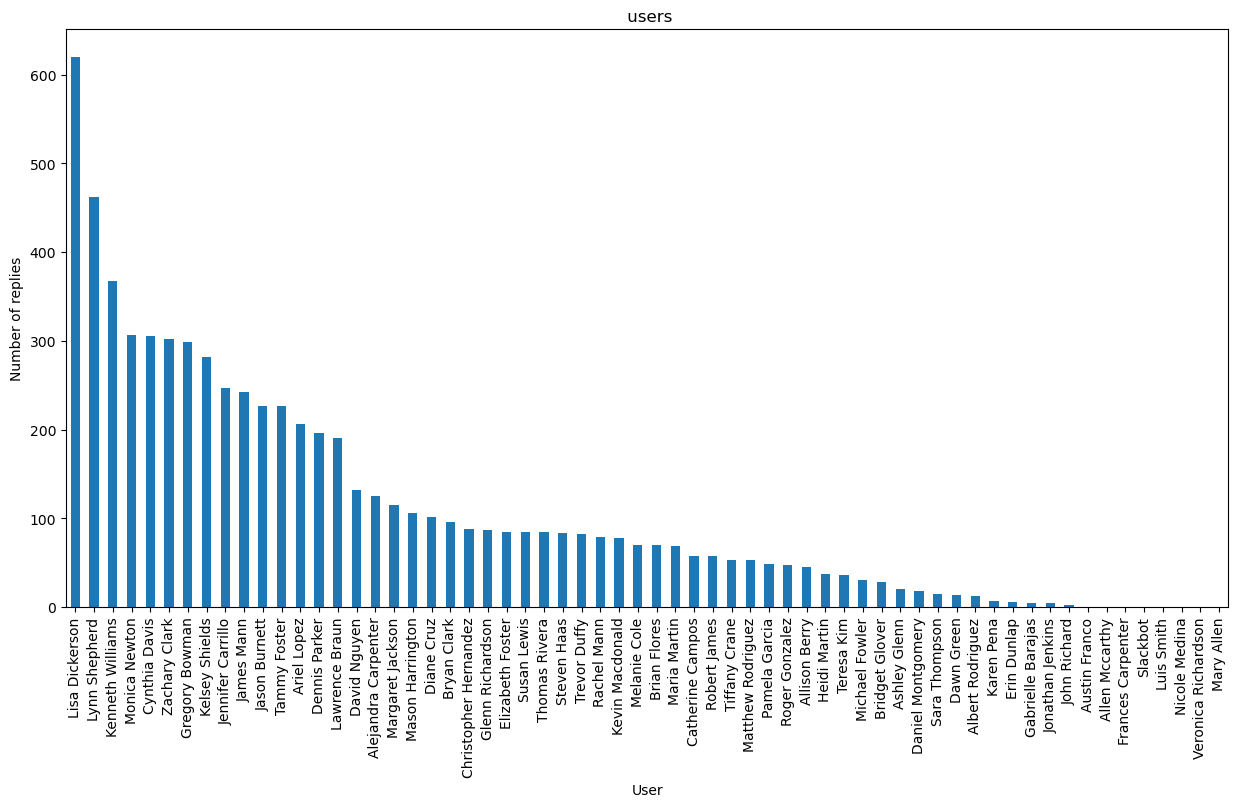

In [89]:
replies_per_user(dframe)

In [ ]:
# what is the time range of the day that most messages are sent?


In [11]:
# what kind of messages are replied faster than others?

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?